<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/H2O/Copy_of_H2O_MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH: H2O

# Install Library

In [1]:
# Insert any install comamnds in this cell
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.6MB 85kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.5-py2.py3-none-any.whl size=164673888 sha256=73e9d07c6b2f8d20a35d073070bfcd7ca7bd509ef1796828259452a5b4282ada
  Stored in directory: /root/.cache/pip/wheels/f7/54/f6/f88d58b676e135bbab981238fcf77f27161ec02b7cc893d8c7
Successfully built h2o


# Preprocessing Section

In [2]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [4]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [6]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [7]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [8]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [9]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [10]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

    
     # Change each positive and negative value to 1 and 0 respectively    
    # imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    # imdb_df = imdb_df.head(25000)

    # Group all the negative reviews and get the first 2500
    # imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:num]
    
    # Group all the positive and get the first 2500
    # imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:num]
    
    # Combine the two split positives and negatives into one dataframe
    imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = imdb_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = imdb_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(len(feature_vector))
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    return feature_vector, labels

# Create Model Section

**Documentation on manipulating data for h2o**

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging.html

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#automl-interface

# Youtube tutorial
https://github.com/srivatsan88/YouTubeLI/blob/master/H2O_AutoML.ipynb

**BIG NOTE**

It seems because of how much H2O automates everything, it only takes in files. Thus a possible solution for running it on the tf idf values is to make a pandas dataframe using the numpy values, then convert it to a csv file and then feed it into the h2o.

There is also h2o.sklearn which allows h2o to work with sklearn and does allow it to work with numpy so maybe test that out.

In [11]:
# Start up h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppnunol6y
  JVM stdout: /tmp/tmppnunol6y/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppnunol6y/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.5
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_xp76zs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [12]:
# X_train, y_train, X_test, y_test = prepare_data()
# num = 100 worked
feature_vector, labels = prepare_data(500)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
tfidf_tf = pd.DataFrame(feature_vector)

# Add the labels
tfidf_tf['labels'] = labels

#==========================================
# Insert the code for running the libraries in here
h2o_tfidf = h2o.H2OFrame(tfidf_tf)
# Set labels to be a categorical field
h2o_tfidf['labels'] = h2o_tfidf['labels'].asfactor()
# print(h2o_tfidf.head())

Dataset loaded
Creating Feature Vector
Feature Vector Created
1000
Execution time is 5.405656337738037 secs
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
y = "labels"
x = h2o_tfidf.columns
x.remove(y)

h2o_tfidf_train, h2o_tfidf_test, h2o_tfidf_valid = h2o_tfidf.split_frame(ratios=[0.7, 0.15])

print("Splits created")

Splits created


In [14]:
from h2o.automl import H2OAutoML

# This is using 10 max models, so it will only create 10
# You can also tell it to not try to use stacked ensemble.
# In this initial test stacked ensemble will be removed to keep it simple
# though deep learning will be allowed since it is good on text data
# You can also set timeboxes for how long models can run
# Verbosity sets whetehr it gives out information while running
# nfolds is for validation, by default it is set to 5 and will create validation splits
# set nfolds to 0 if you have created your own validation split
# Model names go like this h2o_datasize_MaxModels_Time_Seed
h2o_model = H2OAutoML(max_models = 10, seed = 5, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0, project_name="h2o_1000_10_na_5")

In [15]:
exceptions_model = []

# success = False

print("Creating Fit the model")
print("="*50)
start = time.time()
# The server seems to fail sometiems but saw a stack overflow which I think
# said that by running it 3 times, it just works
# Tried it once and now and succeded but then ran again so set it to only run once
for i in range(3):
  # if (!success):
  try:   
    h2o_model.train(x = x, y = y, training_frame = h2o_tfidf_train, validation_frame=h2o_tfidf_valid)

    # Break is here because if it doesnt finish with an error, the models are done    
    break
    # success = True
  except Exception as e:
    # success = False
    exceptions_model.append(e)

print("="*50)
end = time.time()
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)

print(len(exceptions_model))
# print(exceptions_model[0])

Creating Fit the model
AutoML progress: |
19:57:49.424: Project: h2o_1000_10_na_5
19:57:49.428: Cross-validation disabled by user: no fold column nor nfolds > 1.
19:57:49.448: Setting stopping tolerance adaptively based on the training frame: 0.037688918072220454
19:57:49.449: Build control seed: 5
19:57:49.449: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
19:58:05.842: training frame: Frame key: automl_training_py_3_sid_8531    cols: 18198    rows: 629  chunks: 18    size: 26753085  checksum: -6689735093319213294
19:58:05.923: validation frame: Frame key: py_5_sid_8531    cols: 18198    rows: 150  chunks: 18    size: 26348116  checksum: 7065515701422210514
19:58:08.551: leaderboard frame: Frame key: automl_leaderboard_py_3_sid_8531    cols: 18198    rows: 75  chunks: 18    size: 26262482  checksum: 5739860768253177001
19:58:08.552: blending frame: NULL
19:58:08.5

In [27]:
lb = h2o_model.leaderboard
  
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_20210324_195749,0.529202,0.692284,0.480846,0.487179,0.499571,0.249571
XGBoost_3_AutoML_20210324_195749,0.5,0.840366,0.513381,0.5,0.553261,0.306097
GBM_5_AutoML_20210324_195749,0.5,0.71313,0.479364,0.5,0.509361,0.259448
GBM_3_AutoML_20210324_195749,0.456553,0.749349,0.521532,0.5,0.524315,0.274906
DRF_1_AutoML_20210324_195749,0.444444,0.743926,0.475072,0.5,0.523223,0.273763
XGBoost_1_AutoML_20210324_195749,0.441595,0.895166,0.437049,0.487179,0.566869,0.321341
GBM_1_AutoML_20210324_195749,0.440171,0.77439,0.485831,0.5,0.534101,0.285264
GBM_2_AutoML_20210324_195749,0.434473,0.795416,0.479027,0.5,0.541695,0.293433
GBM_4_AutoML_20210324_195749,0.430199,0.817143,0.428395,0.487179,0.551395,0.304037
XGBoost_2_AutoML_20210324_195749,0.428775,0.897921,0.466817,0.5,0.576007,0.331784


In [49]:
# Using the best model make predictions
h2o_tfidf_pred = h2o_model.leader.predict(h2o_tfidf_test)
print(h2o_tfidf_pred)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,negative,positive
positive,0.515287,0.484713
positive,0.506228,0.493772
positive,0.499913,0.500087
positive,0.487296,0.512704
positive,0.499476,0.500524
positive,0.505837,0.494163
positive,0.495263,0.504737
positive,0.501588,0.498412
positive,0.48646,0.51354
positive,0.520768,0.479232


In [50]:
# First 10 predictions
h2o_tfidf_pred.head()
# Shows the probabilities for each one

predict,negative,positive
positive,0.515287,0.484713
positive,0.506228,0.493772
positive,0.499913,0.500087
positive,0.487296,0.512704
positive,0.499476,0.500524
positive,0.505837,0.494163
positive,0.495263,0.504737
positive,0.501588,0.498412
positive,0.48646,0.51354
positive,0.520768,0.479232


In [51]:
# from h20_tfidf_pred, get the positive column where the predict column = positive
positive_values = h2o_tfidf_pred[h2o_tfidf_pred["predict"] == "positive"]["positive"]
negative_values = h2o_tfidf_pred[h2o_tfidf_pred["predict"] == "negative"]["negative"]

# Seperate the values into seperate strings
positive_values = positive_values.get_frame_data().split("\n")
negative_values = negative_values.get_frame_data().split("\n")

# Remove the initial column heading
positive_values.pop(0)
negative_values.pop(0)

# Remove the empy string at the end
positive_values.pop(-1)
negative_values.pop(-1)

# Convert the string values in the list to float
positive_values = [float(i) for i in positive_values]
negative_values = [float(i) for i in positive_values]
# print(positive_values)

In [59]:
y_pred = []

# Get all the individual vales as a list of strings from the predict column
predict_list = h2o_tfidf_pred["predict"].get_frame_data().split("\n")
predict_list.pop(0)
predict_list.pop(-1)

positive_list = h2o_tfidf_pred["positive"].get_frame_data().split("\n")
positive_list.pop(0)
positive_list.pop(-1)

negative_list = h2o_tfidf_pred["negative"].get_frame_data().split("\n")
negative_list.pop(0)
negative_list.pop(-1)

for predict in predict_list:
  # print(predict)
  if predict == "\"positive\"":
    y_pred.append(1)
  else:
    y_pred.append(0)

# Convert the string vlaues to floats and in a numpy array format
# y_pred = np.array([float(i) for i in y_pred])
# y_pred = [float(i) for i in y_pred]
print(len(y_pred))
print(y_pred[0:100])

146
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [53]:
# Map the positive and neagtives to 0 and 1
y_test = h2o_tfidf_test['labels'].asnumeric()

y_test = y_test["labels"].get_frame_data().split("\n")
y_test.pop(0)
y_test.pop(-1)

# Convert to int
# y_test = np.array([int(i) for i in y_test])
y_test = [int(i) for i in y_test]

print(y_test)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]


In [60]:
from sklearn.metrics import accuracy_score
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.4794520547945205


# Manual Metrics

In [61]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[ 0 76]
 [ 0 70]]
True positives: 0.0 %
True negatives: 0.47945 %
False positives: 0.0 %
False negatives: 0.52055 %


In [62]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [63]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

nan


In [64]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.5


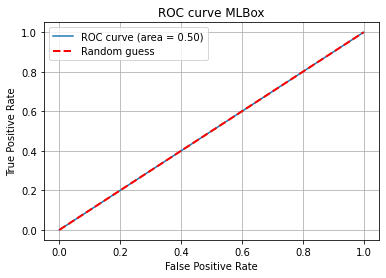

In [37]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve MLBox')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [23]:
# This is a performance report
h2o_model.leader.model_performance(h2o_tfidf_test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2502090844640572
RMSE: 0.5002090407660154
LogLoss: 0.6935409308686474
Null degrees of freedom: 145
Residual degrees of freedom: -162
Null deviance: 202.3802678278769
Residual deviance: 202.51395181364506
AIC: 818.513951813645
AUC: 0.4556390977443609
AUCPR: 0.4345880978194493
Gini: -0.0887218045112782

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47269101496806176: 


,,negative,positive,Error,Rate
0,negative,6.0,70.0,0.9211,(70.0/76.0)
1,positive,1.0,69.0,0.0143,(1.0/70.0)
2,Total,7.0,139.0,0.4863,(71.0/146.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.472691,0.660287,138.0
1,max f2,0.465022,0.827423,142.0
2,max f0point5,0.480324,0.551839,131.0
3,max accuracy,0.556650,0.520548,1.0
4,max precision,0.556650,0.500000,1.0
5,max recall,0.465022,1.000000,142.0
6,max specificity,0.559016,0.986842,0.0
7,max absolute_mcc,0.513297,0.151384,17.0
8,max min_per_class_accuracy,0.496591,0.486842,73.0
9,max mean_per_class_accuracy,0.480324,0.537218,131.0



Gains/Lift Table: Avg response rate: 47.95 %, avg score: 49.69 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.013699,0.542373,1.042857,1.042857,0.500000,0.557833,0.500000,0.557833,0.014286,0.014286,4.285714,4.285714,0.001128
1,2,0.020548,0.523884,0.000000,0.695238,0.000000,0.524922,0.333333,0.546863,0.000000,0.014286,-100.000000,-30.476190,-0.012030
2,3,0.034247,0.523044,0.000000,0.417143,0.000000,0.523474,0.200000,0.537507,0.000000,0.014286,-100.000000,-58.285714,-0.038346
3,4,0.041096,0.522713,2.085714,0.695238,1.000000,0.522791,0.333333,0.535055,0.014286,0.028571,108.571429,-30.476190,-0.024060
4,5,0.054795,0.520799,1.042857,0.782143,0.500000,0.522005,0.375000,0.531792,0.014286,0.042857,4.285714,-21.785714,-0.022932
5,6,0.102740,0.514983,0.595918,0.695238,0.285714,0.517265,0.333333,0.525013,0.028571,0.071429,-40.408163,-30.476190,-0.060150
6,7,0.150685,0.511724,0.893878,0.758442,0.428571,0.513329,0.363636,0.521295,0.042857,0.114286,-10.612245,-24.155844,-0.069925
7,8,0.205479,0.506745,1.303571,0.903810,0.625000,0.509376,0.433333,0.518117,0.071429,0.185714,30.357143,-9.619048,-0.037970
8,9,0.301370,0.503972,0.744898,0.853247,0.357143,0.505006,0.409091,0.513945,0.071429,0.257143,-25.510204,-14.675325,-0.084962
9,10,0.404110,0.500420,0.973333,0.883777,0.466667,0.502380,0.423729,0.511005,0.100000,0.357143,-2.666667,-11.622276,-0.090226


# Get the best model and run inbuilt metrics on it

In [30]:
best_model = h2o.get_model(h2o_model.leader.model_id)
best_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4864785709447344: 


,,negative,positive,Error,Rate
0,negative,110.0,205.0,0.6508,(205.0/315.0)
1,positive,14.0,300.0,0.0446,(14.0/314.0)
2,Total,124.0,505.0,0.3482,(219.0/629.0)


In [31]:
best_model.F1()

[[0.4864785709447344, 0.7326007326007327]]

In [32]:
best_model.accuracy()

[[0.4969517084145459, 0.712241653418124]]

In [39]:
best_model.auc()

0.7737690830047518

In [27]:
best_model.predict(h2o_tfidf_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,negative,positive
positive,0.29305,0.70695
positive,0.409584,0.590416
positive,0.238474,0.761526
positive,0.439225,0.560775
positive,0.467385,0.532615
positive,0.380984,0.619016
positive,0.680671,0.319329
positive,0.421865,0.578135
positive,0.442083,0.557917
positive,0.692578,0.307422


In [ ]:
# This outputs the model as a mojo file which is meant to be a binary object 
# that can work in other languages
h2o_model.leader.download_mojo(path = "/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O")

'/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/XGBoost_2_AutoML_20210224_221844.zip'

In [ ]:
imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/XGBoost_2_AutoML_20210224_221844.zip")
# Using the best model make predictions
predictions = imported_model.predict(h2o_tfidf_test)
# First 10 predictions
predictions.head()

generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1614802690840_1


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomialGeneric: generic
** Reported on train data. **

MSE: 0.11724930804641072
RMSE: 0.3424168629702847
LogLoss: 0.39274892706918024
Mean Per-Class Error: 0.11603769793424967
AUC: 0.9443724379069207
AUCPR: 0.9454697224036777
Gini: 0.8887448758138414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46533888578414917: 


,,negative,positive,Error,Rate
0,negative,266.0,46.0,0.1474,(46.0/312.0)
1,positive,27.0,292.0,0.0846,(27.0/319.0)
2,Total,293.0,338.0,0.1157,(73.0/631.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.465339,0.888889,216.0
1,max f2,0.354182,0.920428,260.0
2,max f0point5,0.585249,0.889371,168.0
3,max accuracy,0.465339,0.884311,216.0
4,max precision,0.973840,1.000000,0.0
5,max recall,0.169793,1.000000,348.0
6,max specificity,0.973840,1.000000,0.0
7,max absolute_mcc,0.465339,0.769837,216.0
8,max min_per_class_accuracy,0.499348,0.880878,202.0
9,max mean_per_class_accuracy,0.465339,0.883962,216.0



Gains/Lift Table: Avg response rate: 50.55 %, avg score: 49.82 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011094,0.946280,1.978056,1.978056,1.000000,0.959436,1.000000,0.959436,0.021944,0.021944,97.805643,97.805643,0.021944
1,2,0.020602,0.920915,1.978056,1.978056,1.000000,0.928076,1.000000,0.944962,0.018809,0.040752,97.805643,97.805643,0.040752
2,3,0.030111,0.912604,1.978056,1.978056,1.000000,0.918054,1.000000,0.936465,0.018809,0.059561,97.805643,97.805643,0.059561
3,4,0.041204,0.898669,1.978056,1.978056,1.000000,0.905624,1.000000,0.928162,0.021944,0.081505,97.805643,97.805643,0.081505
4,5,0.050713,0.883613,1.978056,1.978056,1.000000,0.893275,1.000000,0.921620,0.018809,0.100313,97.805643,97.805643,0.100313
5,6,0.101426,0.839899,1.978056,1.978056,1.000000,0.862566,1.000000,0.892093,0.100313,0.200627,97.805643,97.805643,0.200627
6,7,0.150555,0.800366,1.914248,1.957235,0.967742,0.817429,0.989474,0.867729,0.094044,0.294671,91.424815,95.723478,0.291466
7,8,0.201268,0.765575,1.978056,1.962481,1.000000,0.781071,0.992126,0.845894,0.100313,0.394984,97.805643,96.248118,0.391779
8,9,0.301109,0.679086,1.758272,1.894770,0.888889,0.724383,0.957895,0.805604,0.175549,0.570533,75.827238,89.476984,0.544892
9,10,0.400951,0.604154,1.664079,1.837325,0.841270,0.641163,0.928854,0.764656,0.166144,0.736677,66.407922,83.732514,0.678985




ModelMetricsBinomialGeneric: generic
** Reported on validation data. **

MSE: 0.3027933343808094
RMSE: 0.5502666030033164
LogLoss: 0.8451628931391548
Mean Per-Class Error: 0.45945674044265594
AUC: 0.4909456740442656
AUCPR: 0.5207189858225564
Gini: -0.01810865191146882

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03206312656402588: 


,,negative,positive,Error,Rate
0,negative,0.0,70.0,1.0,(70.0/70.0)
1,positive,0.0,71.0,0.0,(0.0/71.0)
2,Total,0.0,141.0,0.4965,(70.0/141.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.032063,0.669811,140.0
1,max f2,0.032063,0.835294,140.0
2,max f0point5,0.032063,0.559055,140.0
3,max accuracy,0.646269,0.539007,39.0
4,max precision,0.887307,1.000000,0.0
5,max recall,0.032063,1.000000,140.0
6,max specificity,0.887307,1.000000,0.0
7,max absolute_mcc,0.163582,0.183052,129.0
8,max min_per_class_accuracy,0.494156,0.514286,70.0
9,max mean_per_class_accuracy,0.646269,0.540543,39.0



Gains/Lift Table: Avg response rate: 50.35 %, avg score: 48.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014184,0.863493,1.985915,1.985915,1.000000,0.878648,1.000000,0.878648,0.028169,0.028169,98.591549,98.591549,0.028169
1,2,0.021277,0.845121,0.000000,1.323944,0.000000,0.853750,0.666667,0.870349,0.000000,0.028169,-100.000000,32.394366,0.013883
2,3,0.035461,0.840164,0.992958,1.191549,0.500000,0.841871,0.600000,0.858957,0.014085,0.042254,-0.704225,19.154930,0.013682
3,4,0.042553,0.837128,0.000000,0.992958,0.000000,0.837707,0.500000,0.855416,0.000000,0.042254,-100.000000,-0.704225,-0.000604
4,5,0.056738,0.810063,0.992958,0.992958,0.500000,0.823402,0.500000,0.847412,0.014085,0.056338,-0.704225,-0.704225,-0.000805
5,6,0.106383,0.773147,0.567404,0.794366,0.285714,0.788953,0.400000,0.820132,0.028169,0.084507,-43.259557,-20.563380,-0.044064
6,7,0.156028,0.731686,1.134809,0.902689,0.571429,0.745628,0.454545,0.796426,0.056338,0.140845,13.480885,-9.731114,-0.030584
7,8,0.205674,0.704148,1.702213,1.095678,0.857143,0.718950,0.551724,0.777725,0.084507,0.225352,70.221328,9.567751,0.039638
8,9,0.304965,0.638958,1.134809,1.108418,0.571429,0.666926,0.558140,0.741651,0.112676,0.338028,13.480885,10.841795,0.066600
9,10,0.404255,0.556436,0.851107,1.045219,0.428571,0.597707,0.526316,0.706296,0.084507,0.422535,-14.889336,4.521868,0.036821




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-24 22:19:08,0.168 sec,0.0,0.500000,0.693147,0.500000,0.505547,1.000000,0.494453,0.500000,0.693147,0.500000,0.503546,1.000000,0.496454
1,,2021-02-24 22:19:08,0.433 sec,5.0,0.452897,0.599667,0.785020,0.781738,1.695477,0.331220,0.520320,0.738551,0.475151,0.474887,0.000000,0.489362
2,,2021-02-24 22:19:08,0.588 sec,10.0,0.424994,0.544556,0.836061,0.834453,1.978056,0.248811,0.528065,0.759145,0.487525,0.508561,0.992958,0.496454
3,,2021-02-24 22:19:08,0.753 sec,15.0,0.400714,0.496649,0.872810,0.871265,1.978056,0.215531,0.536924,0.790985,0.493360,0.495660,0.000000,0.496454
4,,2021-02-24 22:19:08,0.914 sec,20.0,0.377347,0.453188,0.907438,0.908441,1.978056,0.174326,0.545830,0.815273,0.485915,0.493989,0.992958,0.496454
5,,2021-02-24 22:19:08,1.061 sec,25.0,0.359833,0.421736,0.926327,0.928054,1.978056,0.142631,0.549460,0.838578,0.499598,0.526637,0.992958,0.496454
6,,2021-02-24 22:19:09,1.217 sec,30.0,0.342417,0.392749,0.944372,0.945470,1.978056,0.115689,0.550267,0.845163,0.490946,0.520719,1.985915,0.496454



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,11,48.883972,1.000000,0.051633
1,31,42.746159,0.874441,0.045150
2,14,34.513680,0.706033,0.036455
3,37,31.978783,0.654177,0.033777
4,17,31.398701,0.642311,0.033165
5,42,30.980236,0.633750,0.032723
6,49,28.698563,0.587075,0.030313
7,20,28.396717,0.580900,0.029994
8,33,27.162691,0.555656,0.028690
9,26,25.211611,0.515744,0.026630



See the whole table with table.as_data_frame()

generic prediction progress: |████████████████████████████████████████████| 100%


predict,negative,positive
positive,0.805842,0.194158
positive,0.824793,0.175207
positive,0.327226,0.672774
positive,0.0474267,0.952573
positive,0.83658,0.16342
positive,0.82161,0.17839
positive,0.524807,0.475193
positive,0.68092,0.31908
positive,0.808547,0.191453
positive,0.297972,0.702028


# Test dataset

In [ ]:
# Load the dataset
imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
# imdb_df = pd.read_excel("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.xlsx")

# Group all the negative reviews and get the first 25000
imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])
# imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])
# Group all the positive and get the first 25000
imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"]
# imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1]

# Combine the two split positives and negatives into one dataframe
imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 

# .values on a column of a dataframe returns a numpy array
# This is a numpy array of all the reviews
# initial_reviews = imdb_df['review'].values
feature_vector = imdb_df['test'].values
# print(feature_vector)

# This is a numpy array of all the positive and negativelabels
labels = imdb_df['sentiment'].values

# Shuffle the labesl and feature vector using sklearn shuffle
feature_vector, labels = shuffle(feature_vector, labels)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
tfidf_tf = pd.DataFrame(feature_vector)

# Add the labels
tfidf_tf['labels'] = labels

#==========================================
# Insert the code for running the libraries in here
h2o_tfidf = h2o.H2OFrame(tfidf_tf)
# Set labels to be a categorical field
h2o_tfidf['labels'] = h2o_tfidf['labels'].asfactor()
# print(h2o_tfidf.head())

y = "labels"
x = h2o_tfidf.columns
x.remove(y)

h2o_tfidf_train, h2o_tfidf_test, h2o_tfidf_valid = h2o_tfidf.split_frame(ratios=[0.7, 0.15])

print("Splits created")

imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/XGBoost_2_AutoML_20210224_221844.zip")
# Using the best model make predictions
predictions = imported_model.predict(h2o_tfidf_test)
# First 10 predictions
predictions.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Splits created
generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1614802690840_4


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomialGeneric: generic
** Reported on train data. **

MSE: 0.11724930804641072
RMSE: 0.3424168629702847
LogLoss: 0.39274892706918024
Mean Per-Class Error: 0.11603769793424967
AUC: 0.9443724379069207
AUCPR: 0.9454697224036777
Gini: 0.8887448758138414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46533888578414917: 


,,negative,positive,Error,Rate
0,negative,266.0,46.0,0.1474,(46.0/312.0)
1,positive,27.0,292.0,0.0846,(27.0/319.0)
2,Total,293.0,338.0,0.1157,(73.0/631.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.465339,0.888889,216.0
1,max f2,0.354182,0.920428,260.0
2,max f0point5,0.585249,0.889371,168.0
3,max accuracy,0.465339,0.884311,216.0
4,max precision,0.973840,1.000000,0.0
5,max recall,0.169793,1.000000,348.0
6,max specificity,0.973840,1.000000,0.0
7,max absolute_mcc,0.465339,0.769837,216.0
8,max min_per_class_accuracy,0.499348,0.880878,202.0
9,max mean_per_class_accuracy,0.465339,0.883962,216.0



Gains/Lift Table: Avg response rate: 50.55 %, avg score: 49.82 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011094,0.946280,1.978056,1.978056,1.000000,0.959436,1.000000,0.959436,0.021944,0.021944,97.805643,97.805643,0.021944
1,2,0.020602,0.920915,1.978056,1.978056,1.000000,0.928076,1.000000,0.944962,0.018809,0.040752,97.805643,97.805643,0.040752
2,3,0.030111,0.912604,1.978056,1.978056,1.000000,0.918054,1.000000,0.936465,0.018809,0.059561,97.805643,97.805643,0.059561
3,4,0.041204,0.898669,1.978056,1.978056,1.000000,0.905624,1.000000,0.928162,0.021944,0.081505,97.805643,97.805643,0.081505
4,5,0.050713,0.883613,1.978056,1.978056,1.000000,0.893275,1.000000,0.921620,0.018809,0.100313,97.805643,97.805643,0.100313
5,6,0.101426,0.839899,1.978056,1.978056,1.000000,0.862566,1.000000,0.892093,0.100313,0.200627,97.805643,97.805643,0.200627
6,7,0.150555,0.800366,1.914248,1.957235,0.967742,0.817429,0.989474,0.867729,0.094044,0.294671,91.424815,95.723478,0.291466
7,8,0.201268,0.765575,1.978056,1.962481,1.000000,0.781071,0.992126,0.845894,0.100313,0.394984,97.805643,96.248118,0.391779
8,9,0.301109,0.679086,1.758272,1.894770,0.888889,0.724383,0.957895,0.805604,0.175549,0.570533,75.827238,89.476984,0.544892
9,10,0.400951,0.604154,1.664079,1.837325,0.841270,0.641163,0.928854,0.764656,0.166144,0.736677,66.407922,83.732514,0.678985




ModelMetricsBinomialGeneric: generic
** Reported on validation data. **

MSE: 0.3027933343808094
RMSE: 0.5502666030033164
LogLoss: 0.8451628931391548
Mean Per-Class Error: 0.45945674044265594
AUC: 0.4909456740442656
AUCPR: 0.5207189858225564
Gini: -0.01810865191146882

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03206312656402588: 


,,negative,positive,Error,Rate
0,negative,0.0,70.0,1.0,(70.0/70.0)
1,positive,0.0,71.0,0.0,(0.0/71.0)
2,Total,0.0,141.0,0.4965,(70.0/141.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.032063,0.669811,140.0
1,max f2,0.032063,0.835294,140.0
2,max f0point5,0.032063,0.559055,140.0
3,max accuracy,0.646269,0.539007,39.0
4,max precision,0.887307,1.000000,0.0
5,max recall,0.032063,1.000000,140.0
6,max specificity,0.887307,1.000000,0.0
7,max absolute_mcc,0.163582,0.183052,129.0
8,max min_per_class_accuracy,0.494156,0.514286,70.0
9,max mean_per_class_accuracy,0.646269,0.540543,39.0



Gains/Lift Table: Avg response rate: 50.35 %, avg score: 48.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014184,0.863493,1.985915,1.985915,1.000000,0.878648,1.000000,0.878648,0.028169,0.028169,98.591549,98.591549,0.028169
1,2,0.021277,0.845121,0.000000,1.323944,0.000000,0.853750,0.666667,0.870349,0.000000,0.028169,-100.000000,32.394366,0.013883
2,3,0.035461,0.840164,0.992958,1.191549,0.500000,0.841871,0.600000,0.858957,0.014085,0.042254,-0.704225,19.154930,0.013682
3,4,0.042553,0.837128,0.000000,0.992958,0.000000,0.837707,0.500000,0.855416,0.000000,0.042254,-100.000000,-0.704225,-0.000604
4,5,0.056738,0.810063,0.992958,0.992958,0.500000,0.823402,0.500000,0.847412,0.014085,0.056338,-0.704225,-0.704225,-0.000805
5,6,0.106383,0.773147,0.567404,0.794366,0.285714,0.788953,0.400000,0.820132,0.028169,0.084507,-43.259557,-20.563380,-0.044064
6,7,0.156028,0.731686,1.134809,0.902689,0.571429,0.745628,0.454545,0.796426,0.056338,0.140845,13.480885,-9.731114,-0.030584
7,8,0.205674,0.704148,1.702213,1.095678,0.857143,0.718950,0.551724,0.777725,0.084507,0.225352,70.221328,9.567751,0.039638
8,9,0.304965,0.638958,1.134809,1.108418,0.571429,0.666926,0.558140,0.741651,0.112676,0.338028,13.480885,10.841795,0.066600
9,10,0.404255,0.556436,0.851107,1.045219,0.428571,0.597707,0.526316,0.706296,0.084507,0.422535,-14.889336,4.521868,0.036821




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-24 22:19:08,0.168 sec,0.0,0.500000,0.693147,0.500000,0.505547,1.000000,0.494453,0.500000,0.693147,0.500000,0.503546,1.000000,0.496454
1,,2021-02-24 22:19:08,0.433 sec,5.0,0.452897,0.599667,0.785020,0.781738,1.695477,0.331220,0.520320,0.738551,0.475151,0.474887,0.000000,0.489362
2,,2021-02-24 22:19:08,0.588 sec,10.0,0.424994,0.544556,0.836061,0.834453,1.978056,0.248811,0.528065,0.759145,0.487525,0.508561,0.992958,0.496454
3,,2021-02-24 22:19:08,0.753 sec,15.0,0.400714,0.496649,0.872810,0.871265,1.978056,0.215531,0.536924,0.790985,0.493360,0.495660,0.000000,0.496454
4,,2021-02-24 22:19:08,0.914 sec,20.0,0.377347,0.453188,0.907438,0.908441,1.978056,0.174326,0.545830,0.815273,0.485915,0.493989,0.992958,0.496454
5,,2021-02-24 22:19:08,1.061 sec,25.0,0.359833,0.421736,0.926327,0.928054,1.978056,0.142631,0.549460,0.838578,0.499598,0.526637,0.992958,0.496454
6,,2021-02-24 22:19:09,1.217 sec,30.0,0.342417,0.392749,0.944372,0.945470,1.978056,0.115689,0.550267,0.845163,0.490946,0.520719,1.985915,0.496454



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,11,48.883972,1.000000,0.051633
1,31,42.746159,0.874441,0.045150
2,14,34.513680,0.706033,0.036455
3,37,31.978783,0.654177,0.033777
4,17,31.398701,0.642311,0.033165
5,42,30.980236,0.633750,0.032723
6,49,28.698563,0.587075,0.030313
7,20,28.396717,0.580900,0.029994
8,33,27.162691,0.555656,0.028690
9,26,25.211611,0.515744,0.026630



See the whole table with table.as_data_frame()

generic prediction progress: |████████████████████████████████████████████| 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '1': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '2': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '3': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '4': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '5': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.7/dist-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column '6': substituting in a column of NaN
  warnings.warn(w)
/usr/local

predict,negative,positive
positive,0.583526,0.416474
